In [631]:
import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pkbar
import time
import random

import tensorly as tl
from tensorly.decomposition import matrix_product_state
from tensorly.mps_tensor import mps_to_tensor
tl.set_backend('pytorch')

import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

Using pytorch backend.


In [767]:
def random_mask(length, ratio=0.7):
    keep = []
    while len(keep) < int(ratio * length):
        keep.append(random.randint(0, length - 1))
        keep = list(set(keep))
    return keep

In [769]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

R_vec = R.reshape(s * a)

In [770]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    

    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [771]:
P_mat = torch.empty((s, a, s, a))
for ss in range(s):
    for i in range(a):
        P_mat[:, :, ss, i] = P[:, :, ss]
P_mat = P_mat.reshape(s * a, s * a)

In [772]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [1024]:
class K_Spin(object):
    
    def __init__(self, s_size, a_size, k, data=None):
        '''
        args: 
            s_size: the cardinality of the state space
            a_size: the cardinality of the action space
            k: the number of interacting states
        '''
        super(K_Spin, self).__init__()
        self.k = k
        self.s_size = s_size
        self.a_size = a_size
        
        if data is not None:
            self.leaf = data
        else:
            self.leaf = torch.randn((s_size * a_size, 1))
            self.leaf.requires_grad = True
                
        self.data = self.softmax_by_state()
        self.qubits = self.create_qubits()
        self.outer_product_chain()

    
    def softmax_by_state(self):
        '''
        returns:
            updated data tensor after doing a softmax operation
            with regard to each of the states
        '''
        states = []
        softmax = torch.nn.Softmax(dim=0)
        for s in range(self.s_size):
            state = self.leaf[s * self.a_size : (s+1) * self.a_size, :]
            states.append(softmax(state))
        return torch.cat(states, dim=0)
        
        
    def outer_product_chain(self):
        '''
        modifies:
            connects the qubits into a tensor network that
            computes the outer product when contracted
        '''
        if self.k == 1:
            return
        self.qubits[0][1] ^ self.qubits[1][1]
        for k in range(1, self.k - 1):
            self.qubits[k][2] ^ self.qubits[k + 1][1]


    def create_qubits(self):
        '''
        returns:
            a list of qubits (nodes) with suitable dimensions
            (may contain dummy dimensions)
        '''
        qubits = []
        backend = 'pytorch'
        for i in range(self.k):
            if i == 0 or i == self.k - 1:
                q = tn.Node(self.data, backend=backend)
            else:
                q = tn.Node(self.data.unsqueeze(-1), backend=backend)
            qubits.append(q)
        return qubits

In [1009]:
def initialize_H(k, P, R, s, a, mask, gamma=0.9):
    
    h = torch.zeros([s * a] * k, dtype=torch.float32)
    
    pbar = pkbar.Pbar(name='initialize H, k='+str(k), target=(s * a))
    for i in range(s * a):
        pbar.update(i)
        in_edge = torch.sum(P[..., i // a])
        
        if k == 1:
            if i in mask:
                h[i] = 1

        if k == 2:
            for j in range(s * a):
                if i in mask and j in mask:
                    h[i, j] = P_mat[i, j]
                
        if k == 3:
            for j in range(s * a):
                for l in range(s * a):
                    if i in mask and j in mask and l in mask:
                        h[i, j, l] = P_mat[i, j] * P_mat[j, l]
                    
        if k == 4:
            for j in range(s * a):
                for l in range(s * a):
                    for m in range(s * a):
                        if i in mask and j in mask and l in mask and m in mask:
                            h[i, j, l, m] = P_mat[i, j] * P_mat[j, l] * P_mat[l, m]
                        
        h[i, ...] *= in_edge
        
    for n in range(s * a):
        h[..., n] *= R_vec[n]
        
    h.requires_grad = False
    return tn.Node(h * gamma ** (k - 1), backend=backend)

In [1010]:
def block(*dimensions):
    ''' 
    returns:
        a new matrix for the MPS with random numbers from 0 to 1 
    '''
    size = tuple([x for x in dimensions])
    return torch.randn(size)


def random_mps(rank, dim, bond_dim=20):
    '''
    returns
        a set of randomly initialized tensor cores connected in MPS
        a set of connected edges
    '''
    if rank == 1:
        return [tn.Node(block(dim), backend=backend)], []

    head = [tn.Node(block(dim, bond_dim), backend=backend)]
    mid = [tn.Node(block(bond_dim, dim, bond_dim), backend=backend) for _ in range(rank-2)]
    tail = [tn.Node(block(bond_dim, dim), backend=backend)]

    mps = head + mid + tail
    
    # connect edges to build mps
    connected_edges=[]
    conn = mps[0][1] ^ mps[1][0]
    for k in range(1, rank-1):
        conn = mps[k][2] ^ mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges


def put_mps(tensors):
    '''
    returns
        a set of tensor cores connected in MPS
        a set of connected edges
    '''
    mps = []
    for i in range(len(tensors)):
        mps.append(tn.Node(tensors[i].detach().clone(), backend=backend))
    
    if len(tensors) == 1:
        return mps, []
    
    connected_edges=[]
    conn = mps[0][1] ^ mps[1][0]
    for k in range(1, len(tensors)-1):
        conn = mps[k][2] ^ mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

In [1011]:
def tensor_als(mps, target, omega, lr=0.000001, outer_epochs=10, epochs=10000):
    criterion = torch.nn.MSELoss()
    #for out_e in range(outer_epochs):
        #for i in range(len(mps)):
    op = optim.SGD(mps, lr=lr, momentum=0.9, weight_decay=5e-4)
    for e in range(epochs):
        op.zero_grad()
        loss = criterion(omega * mps_to_tensor(mps), omega * target)
        loss.backward()
        print(loss)
        op.step()
    return mps

In [1012]:
def fill_dims(tensor, dim):
    N = tensor.shape[0]
    order = len(tensor.shape)
    if order == dim:
        return tensor
    pad = torch.zeros([N] * dim, dtype=torch.float32)
    for i in range(N ** order):
        index = np.unravel_index(i, tensor.shape)
        pad[index] = tensor[index]      
    return pad

In [ ]:
k = 3
s, a = 25, 4
chi = 10
mask_vec = random_mask(100, 0.8)

omega = torch.zeros([s * a] * k, dtype=torch.float32)
for i in range(s * a):     
    for j in range(s * a):
        for l in range(s * a):
            if i in mask_vec and j in mask_vec and l in mask_vec:
                omega[i, j, l] = 1

In [1035]:
mode = 'full'#'combined_TT' 
data = torch.randn((s * a, 1), requires_grad=True)
    
H = []
H_core = []

if mode == 'full':
    for i in range(k):
        H.append(initialize_H(i + 1, P, R, s, a, gamma=0.975))
        H_core.append([H[i]])
    
if mode == 'combined_TT':
    tensors = [torch.randn(1, s * a, chi), 
               torch.randn(chi, s * a, chi),#matrix_product_state(H, chi)
               torch.randn(chi, s * a, 1)]

    for t in tensors:
        t.requires_grad = True

    tensors = tensor_als(tensors, H, omega, 1e5)
    tensors[0] = tensors[0].squeeze(0)
    tensors[-1] = tensors[-1].squeeze(-1)
    
    combined_cores, combined_edges = put_mps(tensors)

initialize H, k=1
100/100  [==============================] - 3.4s
initialize H, k=2
100/100  [==============================] - 0.2s
initialize H, k=3
100/100  [==============================] - 9.4s


In [1040]:
lr = 0.000001
energy_history = []
epochs = int(1e3)
Pbar = pkbar.Pbar(name='progress', target=epochs)
op = optim.SGD([data], lr=lr, momentum=0.9, weight_decay=5e-4)

for e in range(epochs):
    op.zero_grad()
    
    new_edges = []
    new_cores = tn.replicate_nodes(combined_cores)
    for j in range(len(combined_cores)):
        edges = new_cores[j].get_all_dangling()
        for edge in edges:
            new_edges.append(edge)
    
    spin = K_Spin(s, a, k, data=data)
    for j in range(k):
        new_edges[j] ^ spin.qubits[j][0]
            
    energy = -contractors.branch(tn.reachable(new_cores[0]), nbranch=1).get_tensor()
    # print(energy)
    energy.backward()
    energy_history.append(energy)
    
    op.step()
    Pbar.update(e)

progress
1000/1000  [==============================] - 4.4s


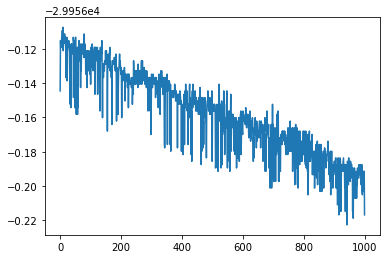

In [1041]:
# with plt.style.context(['science', 'notebook']):
plt.plot(energy_history)
plt.title='Policy Iteration using K-Spin Hamiltonian'
plt.xlabel='Number of iterations'
plt.ylabel='Energy'

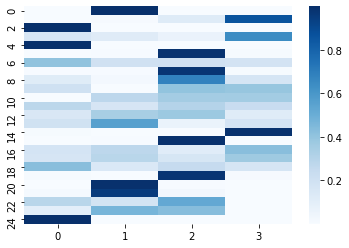

In [1042]:
result = spin.data.reshape(s, a).detach().numpy()
ax = sns.heatmap(result, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [1043]:
policy = torch.empty(s)
p = torch.tensor(result)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[1., 3., 0., 3., 0.],
        [2., 0., 2., 2., 2.],
        [3., 2., 2., 1., 3.],
        [2., 3., 3., 0., 2.],
        [1., 1., 2., 1., 0.]])

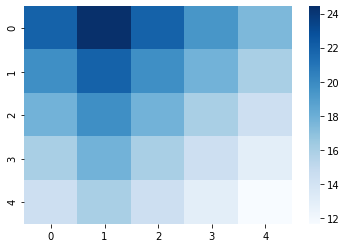

In [1023]:
sns.heatmap(target, cmap='Blues')